In [1]:
import pandas as pd 
import numpy as np
import math
from utlis import *


tmp = pd.read_csv('Weed_Resistance_Data.csv', sep = ',', header=None)
params_in = list(tmp[:21][0])


params_in = np.array(params_in)

In [2]:
General_TillingFrequency = np.loadtxt('Corteva/BMP_Matlab_Code/Tilling_Data.txt')
Herbicide_data = np.loadtxt('Corteva/BMP_Matlab_Code/Herbicide_Data.txt')

In [3]:
from utlis import PrepareParams
import numpy as np 


Params = PrepareParams()


nYears = int(Params.General.nYears)
nCohorts = int(Params.General.nCohorts)

# nYears = 25
# nCohorts = 2
print("starting year and cohort are: ", nYears, " & ", nCohorts)
'''MAIN SIMULATION

Run simulation of nCohorts and nYears, storing information at each step in
the simulation NOTE: (1 x nGeno) variables called curPop (for current
population) and curBank (for current seed bank) will be used to store the
population in the current loop

Each stage in the life cycle is given its own section, denoted by %% and a
horizontal line if editing in Matlab. The format of the code for each
life-cycle stage is:
A. Get parameters relevant for the current stage 
B. Call transition function for the current stage
C. Adjust populations if needed (e.g. extinction)
D. Store current population in population structure array'''

H1_eff = [.9,.3,.7]
H2_eff = [0,0,0]
H3_eff = [0,0,0]
H4_eff = [0,0,0]


for y in range(nYears):
    tempSeedBank = np.zeros(81)

    '''If it till frequency = current year, upper and lower seed banks
    will be swapped, otherwise, nothing changes'''
#
    Population.seedBank[y,:,0],Population.lowerBank[y,:] = deepTill(Population.seedBank[y,:,0],
                                                                Population.lowerBank[y,:],
                                                                Params.General.TillingFreq,y)
    
    
    for c in range(nCohorts):
        print(" y : ", y, " c", c)
        
        ImmSeed = seedImmigration(nGeno)
        seedBank = Population.seedBank[y,:,c]+ ImmSeed
        seedBank = extinction(seedBank,fieldSize)
        fGerm = Params.Germination.survivalFraction[y,c]
        germination = survival(seedBank,fGerm)
        ungerminated = seedBank - germination
        germination = extinction(germination,fieldSize)
        fCult = Params.Cultivation.survivalFraction[y,c]
        cult = survival(germination,fCult)
        cult = extinction(cult,fieldSize)

        # fSS = 1 - Params.Herbicide1.efficacy_SS[0,0]
        # fRS = 1 - Params.Herbicide1.efficacy_RS[0,0]
        # fRR = 1 - Params.Herbicide1.efficacy_RR[0,0]

        fSS = 1 - H1_eff[0]
        fRS = 1 - H1_eff[1]
        fRR = 1 - H1_eff[2]

        targetLocus = Params.Herbicide1.targetLocus

        herbicide1_ = selectiveSurvival(cult,[fSS,fRS,fRR],targetLocus,Params.key)

        herbicide1 = extinction(herbicide1_,fieldSize)

        # fSS = 1 - Params.Herbicide2.efficacy_SS[y,c]
        # fRS = 1 - Params.Herbicide2.efficacy_RS[y,c]
        # fRR = 1 - Params.Herbicide2.efficacy_RR[y,c]

        fSS = 1 - H2_eff[0]
        fRS = 1 - H2_eff[1]
        fRR = 1 - H2_eff[2]

        targetLocus = Params.Herbicide2.targetLocus

        herbicide2_ = selectiveSurvival(herbicide1,[fSS,fRS,fRR],targetLocus,Params.key)
                
        herbicide2 = extinction(herbicide2_,fieldSize)

        fSS = 1 - H3_eff[0]
        fRS = 1 - H3_eff[1]
        fRR = 1 - H3_eff[2]

        targetLocus = Params.Herbicide3.targetLocus

        herbicide3_ = selectiveSurvival(herbicide2,[fSS,fRS,fRR],targetLocus,Params.key)
        herbicide3 = extinction(herbicide3_,fieldSize)

        fSS = 1 - H4_eff[0]
        fRS = 1 - H4_eff[1]
        fRR = 1 - H4_eff[2]

        targetLocus = Params.Herbicide4.targetLocus

        herbicide4_ = selectiveSurvival(herbicide3,[fSS,fRS,fRR],targetLocus,Params.key)
        herbicide4 = extinction(herbicide4_,fieldSize)

        A = Params.Mature.maxplants[y,c]
        B = Params.Mature.cropParam[y,c]
        C = Params.Mature.weedCompetition[y,c]

        mature_ = competition(herbicide4,A,B,C)
        mature = extinction(mature_,fieldSize)
        fHand = Params.Hand.survivalFraction[y,c]

        hand = survival(mature,fHand)
        hand = extinction(hand,fieldSize)
        
        A = Params.SeedProd.maxyield[y,c]
        B = Params.SeedProd.cropParam[y,c]
        C = Params.SeedProd.weedCompetition[y,c]
        sum_hand = float(np.sum(hand))
        seedYield = competition(sum_hand,A,B,C)
        newFrac = mating(hand,Params.General.selfingCoeff, Params.key)
        seedProd_= newFrac*seedYield*Params.General.femaleFrac
        seedProd = extinction(seedProd_,fieldSize)

        targetLocus = 1
        muS2R = Params.Mutation.muS2R_locus1[y,c]
        muR2S = Params.Mutation.muR2S_locus1[y,c]
       
        if muS2R==0 and muR2S==0:
            mutated_locus1 = seedProd
        else:
            mutated_locus1 = mutation(seedProd,muS2R,muR2S,targetLocus,Params.key)
            mutated_locus1 = extinction(mutated_locus1,fieldSize)

        targetLocus = 2
        muS2R = Params.Mutation.muS2R_locus2[y,c]
        muR2S = Params.Mutation.muR2S_locus2[y,c]

        if muS2R==0 and muR2S==0:
            mutated_locus2 = mutated_locus1
        else:
            mutated_locus2 = mutation(mutated_locus1,muS2R,muR2S,targetLocus,Params.key)
            mutated_locus2 = extinction(mutated_locus2,fieldSize)

        targetLocus = 3
        muS2R = Params.Mutation.muS2R_locus3[y,c]
        muR2S = Params.Mutation.muR2S_locus3[y,c]

        if muS2R==0 and muR2S==0:
            mutated_locus3 = mutated_locus2
        else:
            mutated_locus3 = mutation(mutated_locus2,muS2R,muR2S,targetLocus,Params.key)
            mutated_locus3 = extinction(mutated_locus3,fieldSize)

        targetLocus = 4
        muS2R = Params.Mutation.muS2R_locus4[y,c]
        muR2S = Params.Mutation.muR2S_locus4[y,c]

        if muS2R==0 and muR2S==0:
            mutated_locus4 = mutated_locus3
        else:
            mutated_locus4 = mutation(mutated_locus3,muS2R,muR2S,targetLocus,Params.key)
            mutated_locus4 = extinction(mutated_locus4,fieldSize)

        fPred = Params.Predation.survivalFraction[y,c]
        predation = survival(mutated_locus4,fPred)
        predation = extinction(predation,fieldSize)


        # print(predation) 
        if Params.General.seedDelay == 0:
            if c < nCohorts-1:
                Population.seedBank[y,:,c+1] = Population.seedBank[y,:,c+1] + predation + ungerminated
            else:
                tempSeedBank = tempSeedBank + ungerminated + predation
        else:
            tempSeedBank = tempSeedBank + predation
            if c < nCohorts:

                Population.seedBank[y,:,c+1] = Population.seedBank[y,:,c+1] + ungerminated
            else:
                tempSeedBank = tempSeedBank + ungerminated

        Population.immSeed[y,:,c] = ImmSeed
        Population.ungerminated[y,:,c] = ungerminated
        Population.germination[y,:,c] = germination
        Population.herbicide1[y,:,c] = herbicide1
        Population.herbicide2[y,:,c] = herbicide2
        # Population.herbicide3[y,:,c] = herbicide3
        # Population.herbicide4[y,:,c] = herbicide4
        Population.mature[y,:,c] = mature
        Population.hand[y,:,c] = hand
        Population.seedProd[y,:,c] = seedProd
        Population.predation[y,:,c] = predation
        

    if y != nYears-1:
        fWint_upper = Params.Winter.uppersurvivalFraction[y][c]
        fWint_lower = Params.Winter.lowersurvivalFraction[y][c]

        winter_ = survival(tempSeedBank,fWint_upper)
        winter = extinction(winter_,fieldSize)

        Population.winter[y,:] = winter
        Population.seedBank[y+1,:,0] = Population.seedBank[y+1,:,0] + winter
        Population.lowerBank[y+1,:] = survival(Population.lowerBank[y,:],fWint_lower)
        Population.lowerBank[y+1,:] = extinction(Population.lowerBank[y+1,:],fieldSize)

    else:
        print('broken at 50')
        break
    

starting year and cohort are:  25  &  2
 y :  0  c 0
 y :  0  c 1
 y :  1  c 0
 y :  1  c 1
 y :  2  c 0
 y :  2  c 1
 y :  3  c 0
 y :  3  c 1
 y :  4  c 0
 y :  4  c 1
 y :  5  c 0
 y :  5  c 1
 y :  6  c 0
 y :  6  c 1
 y :  7  c 0
 y :  7  c 1
 y :  8  c 0
 y :  8  c 1
 y :  9  c 0
 y :  9  c 1
 y :  10  c 0
 y :  10  c 1
 y :  11  c 0
 y :  11  c 1
 y :  12  c 0
 y :  12  c 1
 y :  13  c 0
 y :  13  c 1
 y :  14  c 0
 y :  14  c 1
 y :  15  c 0
 y :  15  c 1
 y :  16  c 0
 y :  16  c 1
 y :  17  c 0
 y :  17  c 1
 y :  18  c 0
 y :  18  c 1
 y :  19  c 0
 y :  19  c 1
 y :  20  c 0
 y :  20  c 1
 y :  21  c 0
 y :  21  c 1
 y :  22  c 0
 y :  22  c 1
 y :  23  c 0
 y :  23  c 1
 y :  24  c 0
 y :  24  c 1
broken at 50


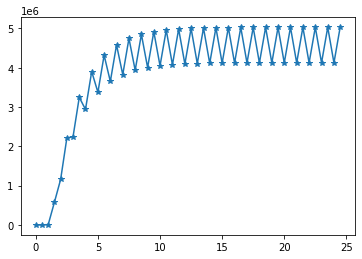

In [4]:
# nYears,nGeno,nCohorts = Population.seedBank.shape
import seaborn as sns
N = nYears*nCohorts

newPop = np.zeros((N,nGeno))

k = 0
for y in range(nYears):
    for c in range(nCohorts):
        newPop[k,:] = Population.seedBank[y,:,c]
        k = k + 1

import matplotlib.pyplot as plt 
time = np.arange(0,N)/nCohorts
pltPop = np.sum(newPop, axis=1)

plt.plot(time,pltPop, '-*')

In [5]:
pd.DataFrame(Params.key)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,...,2.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,2.0
1,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [6]:
Rpop = np.zeros(nYears*nCohorts,)
for G in range(nGeno):
    for L in range(nLoci):
        if Params.key[L,G] == 2 or Params.key[L,G] == 1:
            Rpop =  Rpop + newPop[:,G]
            break

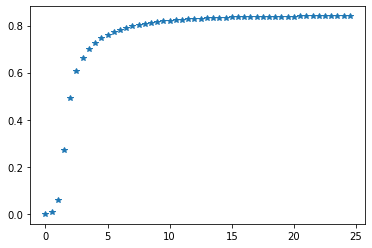

In [7]:
pltPop = Rpop/np.sum(newPop, axis=1)
plt.plot(time,pltPop, '*')

In [8]:
pd.DataFrame(newPop)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,1.000000,2.000000e-08,1.000000e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,105.961955,9.390679e-01,2.100346e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7807.720759,4.670664e+02,7.031280e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,420210.777870,1.452184e+05,1.270051e+04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,586122.348077,4.575076e+05,1.146436e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,867945.142094,9.879929e+05,3.549573e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,763226.313930,1.046039e+06,4.394132e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,971245.847432,1.547863e+06,7.292616e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,808193.153816,1.415774e+06,7.149744e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,991100.755248,1.895209e+06,1.018146e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
pd.DataFrame(np.sum(newPop, axis=1))

,0
0,1.000000e+00
1,1.069031e+02
2,8.281818e+03
3,5.781297e+05
4,1.158274e+06
5,2.210895e+06
6,2.248679e+06
7,3.248370e+06
8,2.938941e+06
9,3.904456e+06
